In [ ]:
#Guassian Kernel Density Estimation

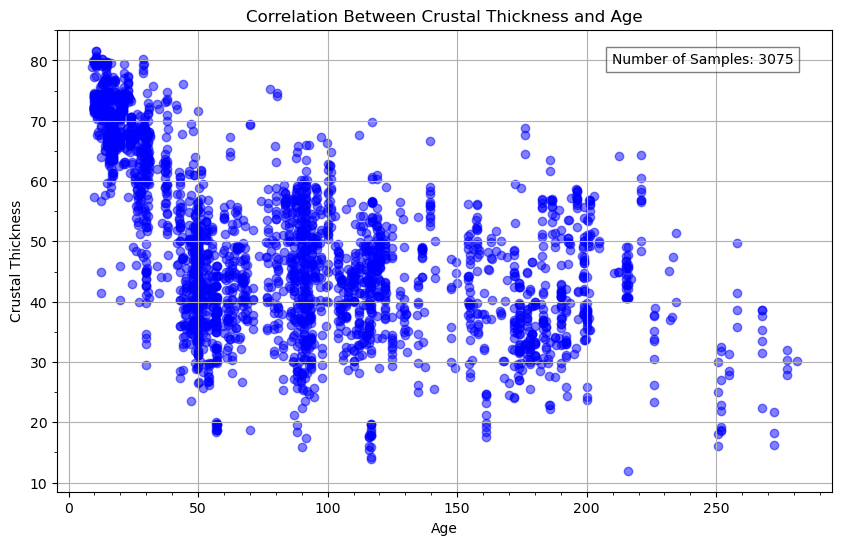

In [3]:
import pandas as pd
import numpy as np
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt

# Read the CSV dataset
df = pd.read_csv("data/Training data with locations and citations/Table S1 (please modify the file, see readme.md).csv")

# Separate the columns
age = df['Age']
crustal_thickness = df['Predicted_Crustal_Thickness']

# Plot the correlation between crustal thickness and age
plt.figure(figsize=(10, 6))

plt.scatter(age, crustal_thickness, color='blue', alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Crustal Thickness')
plt.title('Correlation Between Crustal Thickness and Age')

# Add text annotation for the number of samples
num_samples = len(df)
plt.text(0.95, 0.95, f'Number of Samples: {num_samples}', transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

# Add second tick marks
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))

plt.grid(True)
plt.show()


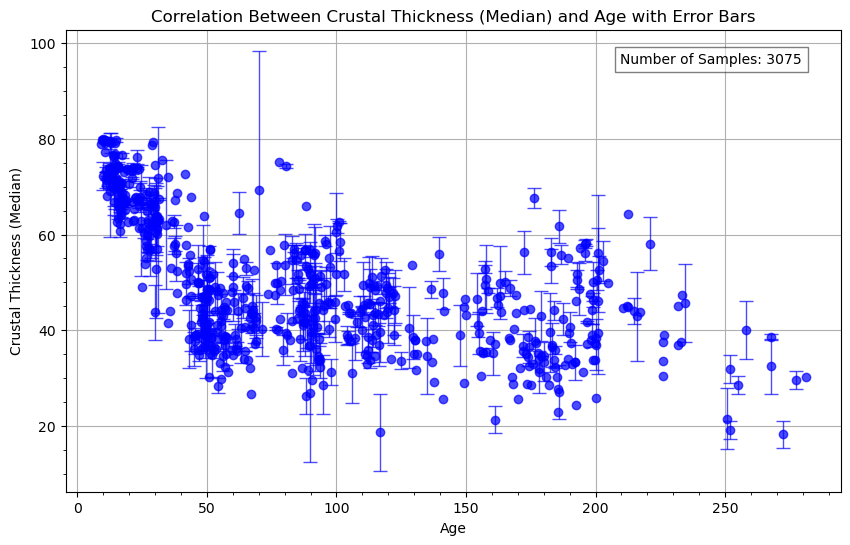

In [4]:
import pandas as pd
import numpy as np
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt

# Read the CSV dataset
df = pd.read_csv("data/Training data with locations and citations/Table S3.csv")

# Group by Age, Latitude, and Longitude and calculate median and standard deviation of crustal thickness
grouped = df.groupby(['Age', 'Lat', 'Lon'])['Predicted_Crustal_Thickness'].agg(['median', 'std']).reset_index()
grouped.rename(columns={'median': 'Median_Crustal_Thickness', 'std': 'Error'}, inplace=True)

# Merge the grouped data back with the original dataframe to map the median and error values
df = df.merge(grouped, on=['Age', 'Lat', 'Lon'], how='left')

# Group by Age to compute the median crustal thickness and error bars
grouped_age = df.groupby('Age').agg({'Median_Crustal_Thickness': 'median', 'Error': 'mean', 'Age error': 'mean'}).reset_index()
grouped_age.rename(columns={'Median_Crustal_Thickness': 'Crustal_Thickness_Median', 'Error': 'Crustal_Thickness_Error', 'Age error': 'Age_Error'}, inplace=True)

# Extract columns for plotting
age = grouped_age['Age']
crustal_thickness_median = grouped_age['Crustal_Thickness_Median']
crustal_thickness_error = grouped_age['Crustal_Thickness_Error']

# Plot the correlation between crustal thickness (median) and age with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(age, crustal_thickness_median, yerr=crustal_thickness_error, fmt='o', color='blue', alpha=0.7, ecolor='blue', elinewidth=1.0, capsize=5)
plt.xlabel('Age')
plt.ylabel('Crustal Thickness (Median)')
plt.title('Correlation Between Crustal Thickness (Median) and Age with Error Bars')

# Add text annotation for the number of samples
num_samples = len(df)
plt.text(0.95, 0.95, f'Number of Samples: {num_samples}', transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

# Add second tick marks
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
plt.grid(True)
plt.show()

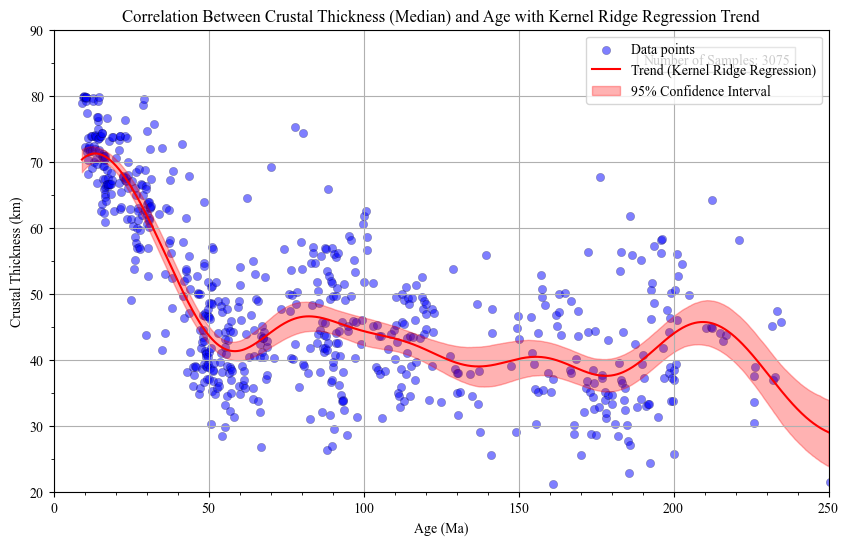

In [6]:
import pandas as pd
import numpy as np
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge

# Set the font to 'Times New Roman'
plt.rcParams['font.family'] = 'Times New Roman'

# Read the CSV dataset
df = pd.read_csv("data/Training data with locations and citations/Table S3.csv")

# Group by Age, Latitude, and Longitude and calculate median and standard deviation of crustal thickness
grouped = df.groupby(['Age', 'Lat', 'Lon'])['Predicted_Crustal_Thickness'].agg(['median', 'std']).reset_index()
grouped.rename(columns={'median': 'Median_Crustal_Thickness', 'std': 'Error'}, inplace=True)

# Merge the grouped data back with the original dataframe to map the median and error values
df = df.merge(grouped, on=['Age', 'Lat', 'Lon'], how='left')

# Group by Age to compute the median crustal thickness and error bars
grouped_age = df.groupby('Age').agg({'Median_Crustal_Thickness': 'median', 'Error': 'mean', 'Age error': 'mean'}).reset_index()
grouped_age.rename(columns={'Median_Crustal_Thickness': 'Crustal_Thickness_Median', 'Error': 'Crustal_Thickness_Error', 'Age error': 'Age_Error'}, inplace=True)

# Extract columns for plotting
age = grouped_age['Age']
crustal_thickness_median = grouped_age['Crustal_Thickness_Median']

# Set up the Kernel Ridge Regression model
bandwidth = 20.0  # Example desired bandwidth
gamma = 1 / (2 * bandwidth ** 2)
kr = KernelRidge(kernel='rbf', alpha=1.0, gamma=gamma)

# Reshape the age array for Kernel Ridge Regression
age_reshaped = age.values.reshape(-1, 1)

# Fit the Kernel Ridge model to the data
kr.fit(age_reshaped, crustal_thickness_median)

# Find the minimum Age value in the dataset
min_age = age.min()

# Create a range of age values for prediction, starting from the minimum Age
age_range = np.linspace(min_age, 250, 1000).reshape(-1, 1)

# Perform predictions with the Kernel Ridge model
predicted_thickness = kr.predict(age_range)

# Bootstrap resampling for confidence intervals
bootstrap_samples = 10000
bootstrap_predictions = np.zeros((bootstrap_samples, age_range.shape[0]))

for i in range(bootstrap_samples):
    resample_idx = np.random.choice(len(age), len(age), replace=True)
    kr.fit(age_reshaped[resample_idx], crustal_thickness_median.values[resample_idx])
    bootstrap_predictions[i, :] = kr.predict(age_range)

# Calculate the 95% confidence interval
ci_lower = np.percentile(bootstrap_predictions, 2.5, axis=0)
ci_upper = np.percentile(bootstrap_predictions, 97.5, axis=0)

# Plot the correlation between crustal thickness (median) and age with Kernel Ridge Regression trend
plt.figure(figsize=(10, 6))

# Scatter plot of data points with transparency
plt.scatter(age, crustal_thickness_median, color='blue', alpha=0.5, edgecolors='black', linewidths=0.25, label='Data points')

# Plot the Kernel Ridge Regression trend line with confidence intervals
plt.plot(age_range, predicted_thickness, color='red', label='Trend (Kernel Ridge Regression)')
plt.fill_between(age_range.flatten(), ci_lower, ci_upper, color='red', alpha=0.3, label='95% Confidence Interval')

plt.xlabel('Age (Ma)')
plt.ylabel('Crustal Thickness (km)')
plt.title('Correlation Between Crustal Thickness (Median) and Age with Kernel Ridge Regression Trend')
plt.xlim(0, 250)
plt.ylim(20, 90)

# Add text annotation for the number of samples
num_samples = len(df)
plt.text(0.95, 0.95, f'Number of Samples: {num_samples}', transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

# Add second tick marks
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
plt.grid(True)

# Add a legend
plt.legend()

# Save the plot to a PDF file
plt.savefig("path to your file/Crustal_thickness_vs_age.pdf", format='pdf', dpi=300, bbox_inches='tight')

plt.show()


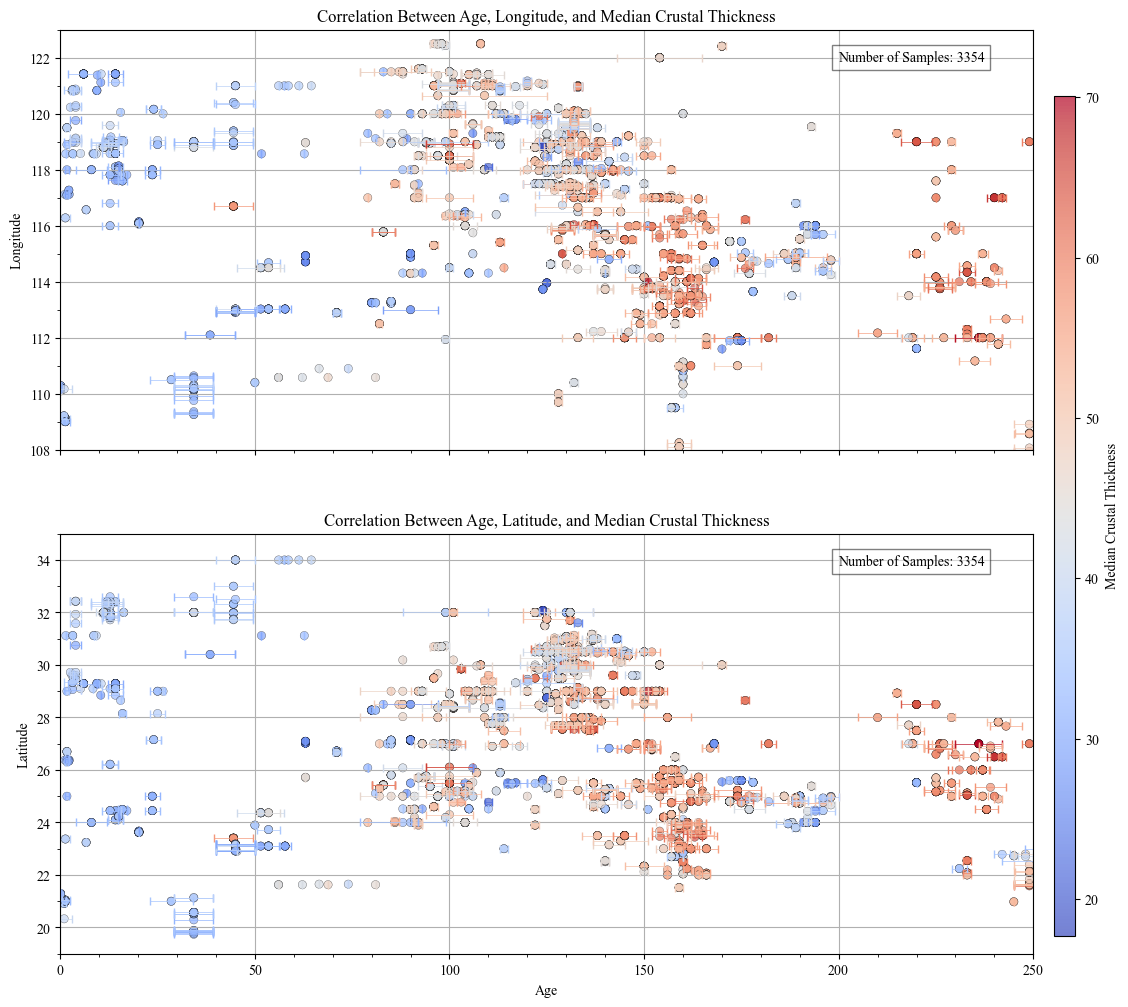

In [2]:
import pandas as pd
import numpy as np
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt

# Set the font to 'Times New Roman'
plt.rcParams['font.family'] = 'Times New Roman'

# Read the CSV dataset
df = pd.read_csv("data/Training data with locations and citations/Table S3.csv")

# Compute the median and standard deviation of crustal thickness for each combination of Age, Latitude, and Longitude
grouped = df.groupby(['Age', 'Lat', 'Lon'])['Predicted_Crustal_Thickness'].agg(['median', 'std']).reset_index()
grouped.rename(columns={'median': 'Median_Crustal_Thickness', 'std': 'Error'}, inplace=True)

# Merge the grouped data back with the original dataframe to map the median and error values
df = df.merge(grouped, on=['Age', 'Lat', 'Lon'], how='left')

# Define the x-axis and y-axis limits
x_limit = (0, 250)  # x-axis range for both plots
y_limit_lon = (108, 123)  # y-axis range for longitude plot
y_limit_lat = (19, 35)  # y-axis range for latitude plot

# Use the 'coolwarm' colormap which transitions from blue to red
cmap = plt.get_cmap('coolwarm')

# Create a figure and two subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# Plot error bars first to make sure they are behind the dots
for ax, y_col in zip(axs, ['Lon', 'Lat']):
    for (age, lat, lon), group in df.groupby(['Age', 'Lat', 'Lon']):
        avg_y = group[y_col].mean()
        color = cmap((group['Median_Crustal_Thickness'].mean() - df['Predicted_Crustal_Thickness'].min()) / (df['Predicted_Crustal_Thickness'].max() - df['Predicted_Crustal_Thickness'].min()))
        ax.errorbar(age, avg_y, xerr=group['Age error'].mean(), fmt='none', ecolor=color, elinewidth=0.5, capsize=3)

# Upper plot: Longitude vs. Age with median crustal thickness
scatter1 = axs[0].scatter(df['Age'], df['Lon'], c=df['Median_Crustal_Thickness'], cmap=cmap, alpha=0.7, edgecolor='black', linewidth=0.25)
axs[0].set_ylabel('Longitude')
axs[0].set_title('Correlation Between Age, Longitude, and Median Crustal Thickness')
axs[0].set_xlim(x_limit)
axs[0].set_ylim(y_limit_lon)
axs[0].grid(True)
axs[0].xaxis.set_minor_locator(MultipleLocator(10))
axs[0].yaxis.set_minor_locator(MultipleLocator(1))

# Lower plot: Latitude vs. Age with median crustal thickness
scatter2 = axs[1].scatter(df['Age'], df['Lat'], c=df['Median_Crustal_Thickness'], cmap=cmap, alpha=0.7, edgecolor='black', linewidth=0.25)
axs[1].set_xlabel('Age')
axs[1].set_ylabel('Latitude')
axs[1].set_title('Correlation Between Age, Latitude, and Median Crustal Thickness')
axs[1].set_xlim(x_limit)
axs[1].set_ylim(y_limit_lat)
axs[1].grid(True)
axs[1].xaxis.set_minor_locator(MultipleLocator(10))
axs[1].yaxis.set_minor_locator(MultipleLocator(1))

# Create color bar manually
cbar_ax = fig.add_axes([0.835, 0.125, 0.015, 0.7])  # [left, bottom, width, height]
cbar = plt.colorbar(scatter1, cax=cbar_ax, orientation='vertical')
cbar.set_label('Median Crustal Thickness')

# Adjust layout to fit the color bar
plt.subplots_adjust(right=0.82)  # Adjust the right margin to fit the color bar

# Show the number of samples on each plot
num_samples = len(df)
axs[0].text(0.95, 0.95, f'Number of Samples: {num_samples}', transform=axs[0].transAxes, verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))
axs[1].text(0.95, 0.95, f'Number of Samples: {num_samples}', transform=axs[1].transAxes, verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

# Save the figure as a PDF
plt.savefig('path to your file/output.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# plot with error bar

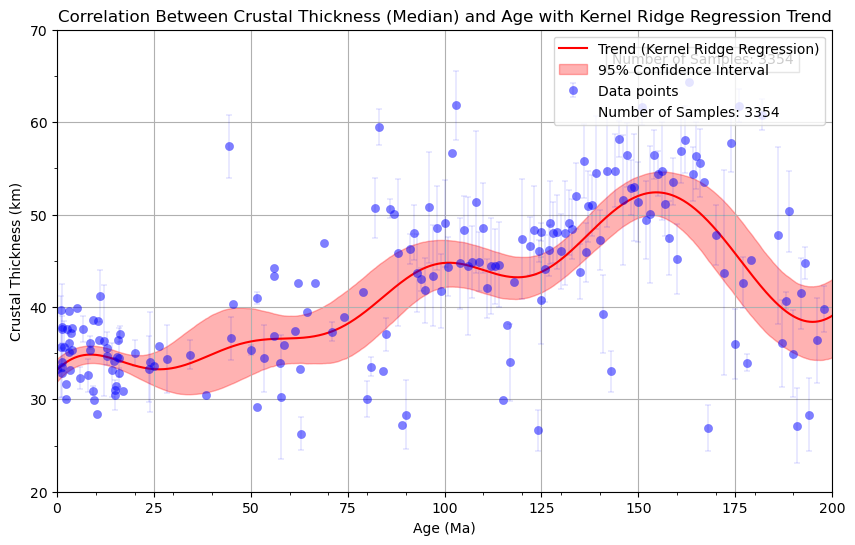

In [1]:
import pandas as pd
import numpy as np
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge

# Read the CSV dataset
df = pd.read_csv("path to your file/Model1_certain area.csv")

# Group by Age, Latitude, and Longitude and calculate median and standard deviation of crustal thickness
grouped = df.groupby(['Age', 'Lat', 'Lon'])['Predicted_Crustal_Thickness'].agg(['median', 'std']).reset_index()
grouped.rename(columns={'median': 'Median_Crustal_Thickness', 'std': 'Error'}, inplace=True)

# Merge the grouped data back with the original dataframe to map the median and error values
df = df.merge(grouped, on=['Age', 'Lat', 'Lon'], how='left')

# Group by Age to compute the median crustal thickness and error bars
grouped_age = df.groupby('Age').agg({'Median_Crustal_Thickness': 'median', 'Error': 'mean', 'Age error': 'mean'}).reset_index()
grouped_age.rename(columns={'Median_Crustal_Thickness': 'Crustal_Thickness_Median', 'Error': 'Crustal_Thickness_Error', 'Age error': 'Age_Error'}, inplace=True)

# Extract columns for plotting
age = grouped_age['Age']
crustal_thickness_median = grouped_age['Crustal_Thickness_Median']
crustal_thickness_error = grouped_age['Crustal_Thickness_Error']

# Plot the correlation between crustal thickness (median) and age with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(age, crustal_thickness_median, yerr=crustal_thickness_error, fmt='o', color='blue', ecolor='blue', alpha=0.5, elinewidth=0.25, capsize=2.5, markeredgewidth=0.25, label='Data points')
plt.xlabel('Age (Ma)')
plt.ylabel('Crustal Thickness (km)')
plt.title('Correlation Between Crustal Thickness (Median) and Age with Error Bars')

# Add text annotation for the number of samples
num_samples = len(df)
plt.text(0.95, 0.95, f'Number of Samples: {num_samples}', transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

# Add second tick marks
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
plt.grid(True)

# Kernel Ridge Regression
bandwidth = 20.0  # Example desired bandwidth
gamma = 1 / (2 * bandwidth ** 2)
kr = KernelRidge(kernel='rbf', alpha=1.0, gamma=gamma)

# Fit the Kernel Ridge model to the data (only the scatter points are used for fitting)
age_reshaped = age.values.reshape(-1, 1)
kr.fit(age_reshaped, crustal_thickness_median)

# Create a range of age values for prediction, only where data exists
age_range = np.linspace(age.min(), 250, 1000).reshape(-1, 1)

# Perform predictions with the Kernel Ridge model
predicted_thickness = kr.predict(age_range)

# Bootstrap resampling for confidence intervals
bootstrap_samples = 10000
bootstrap_predictions = np.zeros((bootstrap_samples, age_range.shape[0]))

for i in range(bootstrap_samples):
    resample_idx = np.random.choice(len(age), len(age), replace=True)
    kr.fit(age_reshaped[resample_idx], crustal_thickness_median.values[resample_idx])
    bootstrap_predictions[i, :] = kr.predict(age_range)

# Calculate the 95% confidence interval
ci_lower = np.percentile(bootstrap_predictions, 2.5, axis=0)
ci_upper = np.percentile(bootstrap_predictions, 97.5, axis=0)

# Plot the Kernel Ridge Regression trend line with confidence intervals
plt.plot(age_range, predicted_thickness, color='red', label='Trend (Kernel Ridge Regression)')
plt.fill_between(age_range.flatten(), ci_lower, ci_upper, color='red', alpha=0.3, label='95% Confidence Interval')

# Set plot limits and labels
plt.xlim(0, 200)
plt.ylim(20, 70)
plt.xlabel('Age (Ma)')
plt.ylabel('Crustal Thickness (km)')
plt.title('Correlation Between Crustal Thickness (Median) and Age with Kernel Ridge Regression Trend')

# Add number of samples to the legend
num_samples = len(df)
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none', label=f'Number of Samples: {num_samples}'))
plt.legend(handles=handles, loc='upper right')

# Add second tick marks
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
plt.grid(True)

# Save the plot to a PDF file
plt.savefig("path to your file/figures/Crustal_thickness_vs_age.pdf", format='pdf', dpi=300, bbox_inches='tight')

plt.show()